In [1]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import datetime
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torchvision
import torchsummary

import pretrainedmodels
import efficientnet_pytorch

from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score

In [2]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

In [3]:
result_pkl_list = []
for root, dirs, files in os.walk(os.path.join('results')):
    for file in files:
        if file[-3:] =='pkl':
            result_pkl_list.append(os.path.join(root, file))

In [4]:
result_info_list = []
for result in result_pkl_list:
    model = result.split('/')[1].split('_')[0]
    transfer = result.split('/')[1].split('_')[1]
    noise = result.split('/')[2].split('_')[2]
    cv = result.split('/')[2].split('_')[3].split('.')[0]
    result_info_list.append([model, transfer, noise, cv, result])

In [5]:
for result_info in result_info_list:
    with open(result_info[4], 'rb') as f:
        out = pickle.load(f)
    result_info.append(out[1])
    result_info.append(out[2])
    result_info.append(out[3])

In [6]:
result_df = pd.DataFrame(result_info_list, columns = ['model', 'transfer', 'noise', 'cv', 'path', 'accuracy', 'true', 'pred'])

In [7]:
top_result_list = []
for name, group in result_df.groupby(['model', 'transfer', 'noise']):
    group['accuracy_mean'] = group['accuracy'].mean()
    group['accuracy_list'] = [group['accuracy'].tolist()] * len(group)
    group['balanced_accuracy_score'] = group.apply(lambda s: balanced_accuracy_score(s['true'], s['pred']), axis=1)
    group['balanced_accuracy_max'] = group['balanced_accuracy_score'].max()
    group['balanced_accuracy_mean'] = group['balanced_accuracy_score'].mean()
    group['balanced_accuracy_std'] = group['balanced_accuracy_score'].std()
    group['balanced_accuracy_list'] = [group['balanced_accuracy_score'].tolist()] * len(group)
    group['f1_score'] = group.apply(lambda s: f1_score(s['true'], s['pred'], average='weighted'), axis=1)
    group['f1_score_max'] = group['f1_score'].max()
    group['f1_score_mean'] = group['f1_score'].mean()
    group['f1_score_std'] = group['f1_score'].std()
    group['f1_score_list'] = [group['f1_score'].tolist()] * len(group)
    #top_result_list.append(group.iloc[group['accuracy'].argmax()])
    top_result_list.append(group.iloc[group['f1_score'].argmax()])
top_result_df = pd.DataFrame(top_result_list)

top_result_df_selected = top_result_df.copy()
top_result_df_selected = top_result_df_selected[['noise', 'model', 'transfer', 'balanced_accuracy_max', 'balanced_accuracy_mean', 'balanced_accuracy_std', 'f1_score_max', 'f1_score_mean', 'f1_score_std']]
top_result_df_selected = top_result_df_selected.sort_values(by=['noise', 'model', 'transfer'], ascending=[True, True, True])
top_result_df_selected.to_csv('out.csv')

In [8]:
top_result_list = []
for name, group in result_df.groupby(['model', 'transfer', 'noise']):
    group['accuracy_mean'] = group['accuracy'].mean()
    group['accuracy_list'] = [group['accuracy'].tolist()] * len(group)
    group['balanced_accuracy_score'] = group.apply(lambda s: balanced_accuracy_score(s['true'], s['pred']), axis=1)
    group['balanced_accuracy_mean'] = group['balanced_accuracy_score'].mean()
    group['balanced_accuracy_list'] = [group['balanced_accuracy_score'].tolist()] * len(group)
    group['f1_score'] = group.apply(lambda s: f1_score(s['true'], s['pred'], average='weighted'), axis=1)
    group['f1_score_list'] = [group['f1_score'].tolist()] * len(group)
    #top_result_list.append(group.iloc[group['accuracy'].argmax()])
    top_result_list.append(group.iloc[group['f1_score'].argmax()])

In [9]:
top_result_df = pd.DataFrame(top_result_list)
top_result_df = top_result_df.loc[top_result_df['transfer']=='True']
top_result_df

,model,transfer,noise,cv,path,accuracy,true,pred,accuracy_mean,accuracy_list,balanced_accuracy_score,balanced_accuracy_mean,balanced_accuracy_list,f1_score,f1_score_list
60,Resnet18,True,0.00,3,results/Resnet18_True/test_result_0.00_3.pkl,94.594595,"[1, 3, 0, 0, 3, 1, 0, 4, 1, 3, 4, 0, 2, 3, 3, ...","[1, 3, 0, 0, 3, 1, 0, 4, 1, 3, 4, 4, 2, 3, 3, ...",92.432432,"[94.5945945945946, 91.89189189189189, 89.18918...",0.931818,0.904545,"[0.9318181818181819, 0.8818181818181818, 0.863...",0.945946,"[0.9459459459459459, 0.913714957193218, 0.8870..."
62,Resnet18,True,0.01,4,results/Resnet18_True/test_result_0.01_4.pkl,94.594595,"[1, 2, 3, 3, 3, 4, 3, 3, 2, 0, 1, 3, 1, 2, 0, ...","[1, 2, 3, 3, 3, 4, 3, 3, 2, 0, 1, 3, 1, 2, 0, ...",89.729730,"[94.5945945945946, 81.08108108108108, 86.48648...",0.931818,0.869481,"[0.9318181818181819, 0.7564935064935066, 0.813...",0.945946,"[0.9459459459459459, 0.8132264132264132, 0.863..."
61,Resnet18,True,0.03,2,results/Resnet18_True/test_result_0.03_2.pkl,86.486486,"[1, 0, 1, 2, 3, 0, 4, 3, 3, 0, 0, 2, 1, 3, 0, ...","[1, 4, 1, 2, 3, 0, 4, 3, 3, 1, 0, 2, 1, 3, 0, ...",84.864865,"[86.48648648648648, 86.48648648648648, 83.7837...",0.877273,0.834545,"[0.8772727272727273, 0.8772727272727273, 0.795...",0.862079,"[0.8620791844476056, 0.8620791844476056, 0.836..."
78,Resnet18,True,0.05,1,results/Resnet18_True/test_result_0.05_1.pkl,83.783784,"[1, 3, 3, 4, 2, 3, 0, 0, 0, 2, 0, 2, 2, 0, 1, ...","[3, 3, 3, 4, 2, 3, 0, 0, 0, 2, 0, 2, 2, 4, 1, ...",82.162162,"[83.78378378378379, 81.08108108108108, 81.0810...",0.848701,0.822857,"[0.7954545454545455, 0.840909090909091, 0.8090...",0.839189,"[0.8334942084942084, 0.8037577050734944, 0.808..."
100,Resnet34,True,0.00,3,results/Resnet34_True/test_result_0.00_3.pkl,94.594595,"[4, 0, 1, 4, 1, 1, 0, 3, 1, 2, 0, 4, 4, 1, 0, ...","[0, 0, 1, 4, 1, 1, 0, 3, 1, 2, 4, 4, 4, 1, 0, ...",93.513514,"[94.5945945945946, 94.5945945945946, 91.891891...",0.931818,0.918182,"[0.9318181818181819, 0.9318181818181819, 0.881...",0.945946,"[0.9459459459459459, 0.9459459459459459, 0.914..."
102,Resnet34,True,0.01,4,results/Resnet34_True/test_result_0.01_4.pkl,97.297297,"[0, 4, 0, 0, 0, 0, 1, 3, 0, 3, 1, 3, 0, 3, 1, ...","[4, 4, 0, 0, 0, 0, 1, 3, 0, 3, 1, 3, 0, 3, 1, ...",90.810811,"[97.29729729729729, 86.48648648648648, 83.7837...",0.981818,0.880909,"[0.9818181818181818, 0.8136363636363637, 0.795...",0.973831,"[0.9738309738309738, 0.8638352638352639, 0.836..."
103,Resnet34,True,0.03,4,results/Resnet34_True/test_result_0.03_4.pkl,94.594595,"[0, 0, 1, 4, 3, 3, 2, 4, 0, 4, 2, 1, 0, 3, 2, ...","[0, 0, 1, 4, 3, 3, 2, 4, 4, 4, 2, 1, 1, 3, 2, ...",88.108108,"[89.1891891891892, 94.5945945945946, 89.189189...",0.963636,0.850000,"[0.8636363636363636, 0.9636363636363636, 0.831...",0.945646,"[0.8918918918918919, 0.9456456456456456, 0.886..."
114,Resnet34,True,0.05,0,results/Resnet34_True/test_result_0.05_0.pkl,91.891892,"[1, 3, 0, 0, 0, 3, 1, 2, 2, 3, 0, 1, 0, 3, 4, ...","[1, 3, 0, 1, 0, 3, 1, 2, 2, 3, 0, 1, 0, 3, 0, ...",84.864865,"[86.48648648648648, 83.78378378378379, 91.8918...",0.881818,0.826234,"[0.8032467532467532, 0.859090909090909, 0.8818...",0.912573,"[0.860118240553023, 0.836969111969112, 0.91257..."
6,Resnet50,True,0.00,2,results/Resnet50_True/test_result_0.00_2.pkl,94.594595,"[4, 1, 0, 4, 2, 0, 3, 1, 3, 3, 0, 2, 3, 1, 4, ...","[4, 1, 0, 0, 2, 0, 3, 1, 3, 3, 0, 2, 3, 1, 4, ...",93.513514,"[91.89189189189189, 94.5945945945946, 94.59459...",0.931818,0.911818,"[0.8818181818181818, 0.9318181818181819, 0.931...",0.945946,"[0.914890045324828, 0.9459459459459459, 0.9459..."
11,Resnet50,True,0.01,2,results/Resnet50_True/test_result_0.01_2.pkl,94.594595,"[3, 1, 0, 0, 3, 1, 4, 3, 2, 1, 0, 1, 0, 2, 3, ...","[3, 1, 0, 0, 3, 1, 0, 3, 2, 1, 0, 1, 0, 2, 3, ...",92.972973,"[91.89189189189189, 91.89189189189189, 91.8918...",0.931818,0.901818,"[0.9136363636363637, 0.85, 0.8818181818181818,...",0.945946,"[0.9178893178893179, 0.9134491634491634, 0.914..."


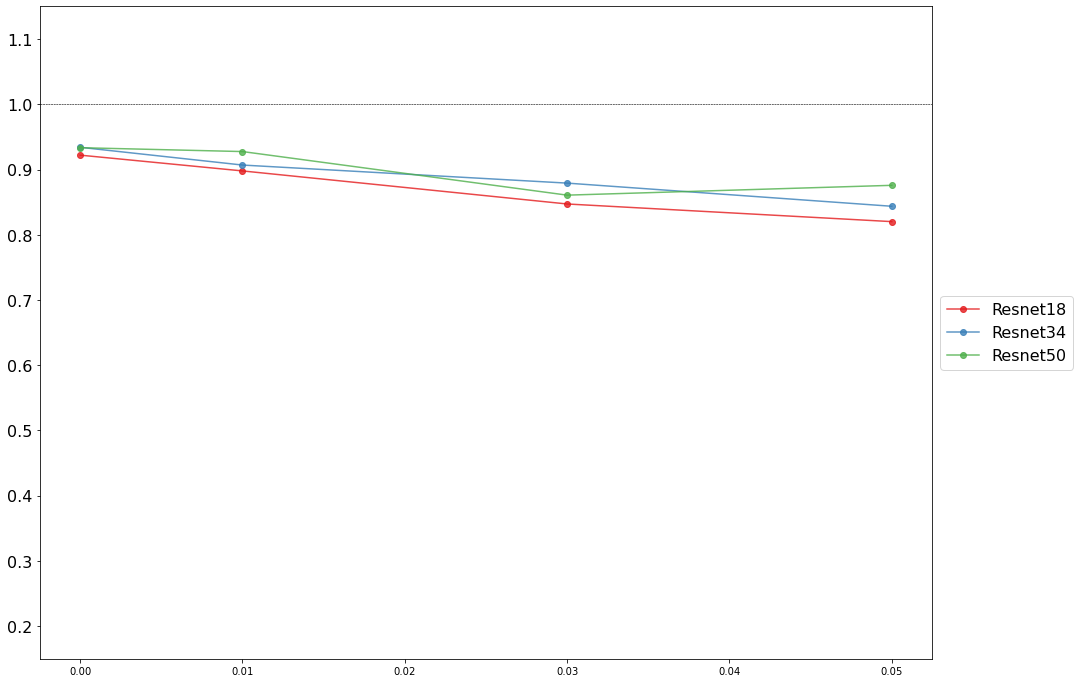

In [10]:
plt.figure(figsize=(16,12))
model_name_set = ['Resnet18', 'Resnet34', 'Resnet50']
for model_name in model_name_set:
    df = top_result_df.loc[top_result_df['model'] == model_name]

    x = [float(n) for n in df['noise']]
    #y = df['accuracy']
    y = df['f1_score_list'].apply(lambda s: np.mean(np.sort(s))).to_numpy()
    #y_std = df['accuracy_list'].apply(lambda s: np.std(np.sort(s))).to_numpy()
    
    plt.plot(x,y, '-o', label=model_name, alpha=0.8)
    #plt.fill_between(x, y-y_std, y+y_std, alpha=0.2)
    #plt.xticks(x)
    plt.ylim(0.15,1.15)
    plt.yticks(np.linspace(0.20, 1.10,10), fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.axhline(y=1.0, linewidth = 0.5, linestyle='--', color='k', alpha=0.5)
plt.show()

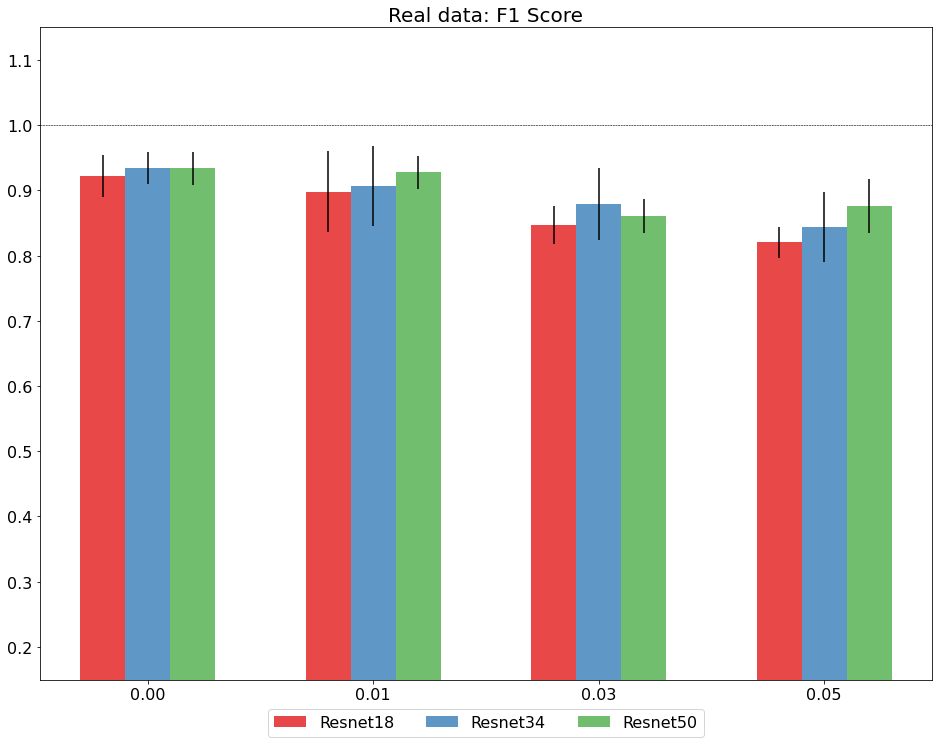

In [11]:
plt.figure(figsize=(16,12))
i=0
model_name_set = ['Resnet18', 'Resnet34', 'Resnet50']
for model_name in model_name_set:
    df = top_result_df.loc[top_result_df['model'] == model_name]

    x = [str(n) for n in df['noise']]
    #y = df['accuracy']
    y = df['f1_score_list'].apply(lambda s: np.mean(np.sort(s))).to_numpy()
    y_std = df['f1_score_list'].apply(lambda s: np.std(np.sort(s))).to_numpy()
    
    plt.bar(np.array(range(len(x)))+0.2*i, y, yerr=y_std+0.01, width=0.2, label=model_name, alpha=0.8)
    #plt.fill_between(x, y-y_std, y+y_std, alpha=0.2)
    plt.xticks(np.array(range(len(x)))-0.2+0.2*i, x, fontsize=16)
    plt.ylim(0.15,1.15)
    plt.yticks(np.linspace(0.20, 1.10,10), fontsize=16)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol = 3, fontsize=16)
    plt.axhline(y=1.0, linewidth = 0.5, linestyle='--', color='k', alpha=0.5)
    i+=1
plt.title('Real data: F1 Score', fontsize=20)
plt.show()

In [12]:
top_result_df = pd.DataFrame(top_result_list)
top_result_df = top_result_df.loc[top_result_df['transfer']=='False']
top_result_df

,model,transfer,noise,cv,path,accuracy,true,pred,accuracy_mean,accuracy_list,balanced_accuracy_score,balanced_accuracy_mean,balanced_accuracy_list,f1_score,f1_score_list
20,Resnet18,False,0.00,3,results/Resnet18_False/test_result_0.00_3.pkl,94.594595,"[1, 3, 0, 4, 0, 2, 0, 3, 1, 3, 0, 4, 1, 1, 4, ...","[1, 3, 0, 0, 0, 2, 4, 3, 1, 3, 0, 4, 1, 1, 4, ...",91.351351,"[94.5945945945946, 91.89189189189189, 89.18918...",0.931818,0.890909,"[0.9318181818181819, 0.8818181818181818, 0.863...",0.945946,"[0.9459459459459459, 0.914890045324828, 0.8870..."
30,Resnet18,False,0.01,3,results/Resnet18_False/test_result_0.01_3.pkl,94.594595,"[2, 1, 3, 4, 0, 3, 0, 4, 1, 0, 0, 0, 3, 0, 3, ...","[2, 1, 3, 4, 0, 3, 0, 4, 1, 0, 0, 0, 3, 4, 3, ...",90.810811,"[89.1891891891892, 89.1891891891892, 86.486486...",0.931818,0.893636,"[0.8954545454545455, 0.8636363636363636, 0.845...",0.945946,"[0.8918918918918919, 0.8870012870012869, 0.859..."
21,Resnet18,False,0.03,2,results/Resnet18_False/test_result_0.03_2.pkl,86.486486,"[2, 1, 3, 3, 0, 3, 2, 0, 0, 3, 0, 0, 0, 1, 0, ...","[2, 1, 3, 3, 0, 3, 2, 4, 0, 3, 1, 0, 0, 1, 1, ...",84.324324,"[86.48648648648648, 86.48648648648648, 83.7837...",0.877273,0.837273,"[0.8772727272727273, 0.909090909090909, 0.8272...",0.862079,"[0.8620791844476056, 0.8575370068976207, 0.831..."
34,Resnet18,False,0.05,0,results/Resnet18_False/test_result_0.05_0.pkl,91.891892,"[0, 3, 1, 0, 3, 0, 0, 2, 3, 2, 4, 3, 3, 4, 0, ...","[0, 3, 1, 1, 3, 0, 0, 2, 3, 2, 4, 3, 3, 4, 0, ...",81.621622,"[81.08108108108108, 81.08108108108108, 91.8918...",0.881818,0.795974,"[0.7772727272727273, 0.7987012987012987, 0.881...",0.912573,"[0.8064671814671815, 0.8049339957806776, 0.912..."
46,Resnet34,False,0.00,2,results/Resnet34_False/test_result_0.00_2.pkl,94.594595,"[0, 1, 2, 0, 2, 4, 3, 1, 3, 4, 4, 4, 3, 0, 2, ...","[0, 1, 2, 0, 2, 4, 3, 1, 3, 4, 4, 0, 3, 0, 2, ...",92.972973,"[91.89189189189189, 94.5945945945946, 94.59459...",0.931818,0.901818,"[0.8818181818181818, 0.9318181818181819, 0.931...",0.945946,"[0.914890045324828, 0.9459459459459459, 0.9459..."
51,Resnet34,False,0.01,2,results/Resnet34_False/test_result_0.01_2.pkl,94.594595,"[3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 3, 0, 3, 1, 4, ...","[3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 3, 0, 3, 1, 4, ...",90.270270,"[89.1891891891892, 86.48648648648648, 86.48648...",0.931818,0.877273,"[0.8954545454545455, 0.7818181818181819, 0.845...",0.945946,"[0.8898648648648648, 0.8585193889541717, 0.859..."
53,Resnet34,False,0.03,3,results/Resnet34_False/test_result_0.03_3.pkl,100.000000,"[3, 3, 2, 0, 3, 3, 3, 1, 0, 2, 1, 3, 3, 0, 4, ...","[3, 3, 2, 0, 3, 3, 3, 1, 0, 2, 1, 3, 3, 0, 4, ...",89.189189,"[89.1891891891892, 86.48648648648648, 100.0, 8...",1.000000,0.882727,"[0.8954545454545455, 0.8772727272727273, 1.0, ...",1.000000,"[0.8918918918918919, 0.8620791844476056, 1.0, ..."
54,Resnet34,False,0.05,0,results/Resnet34_False/test_result_0.05_0.pkl,86.486486,"[4, 3, 2, 3, 0, 2, 0, 3, 0, 3, 3, 3, 1, 1, 0, ...","[4, 3, 2, 3, 0, 2, 0, 3, 4, 3, 3, 3, 1, 1, 0, ...",82.702703,"[81.08108108108108, 86.48648648648648, 86.4864...",0.845455,0.801039,"[0.7454545454545455, 0.8136363636363637, 0.845...",0.859234,"[0.8102102102102102, 0.8454204204204205, 0.859..."
80,Resnet50,False,0.00,3,results/Resnet50_False/test_result_0.00_3.pkl,94.594595,"[0, 2, 0, 1, 3, 3, 1, 3, 3, 1, 2, 0, 0, 0, 0, ...","[0, 2, 0, 1, 3, 3, 1, 3, 3, 1, 2, 0, 0, 0, 0, ...",91.891892,"[94.5945945945946, 89.1891891891892, 94.594594...",0.931818,0.898831,"[0.9318181818181819, 0.8954545454545455, 0.9, ...",0.945946,"[0.9459459459459459, 0.8898648648648648, 0.939..."
91,Resnet50,False,0.01,2,results/Resnet50_False/test_result_0.01_2.pkl,94.594595,"[4, 0, 4, 1, 0, 1, 2, 0, 1, 3, 3, 1, 0, 2, 0, ...","[4, 0, 4, 1, 0, 1, 2, 0, 1, 3, 3, 1, 0, 2, 0, ...",91.351351,"[89.1891891891892, 94.5945945945946, 89.189189...",0.931818,0.884545,"[0.8954545454545455, 0.9, 0.8636363636363636, ...",0.945946,"[0.8898648648648648, 0.939189189189189, 0.8870..."


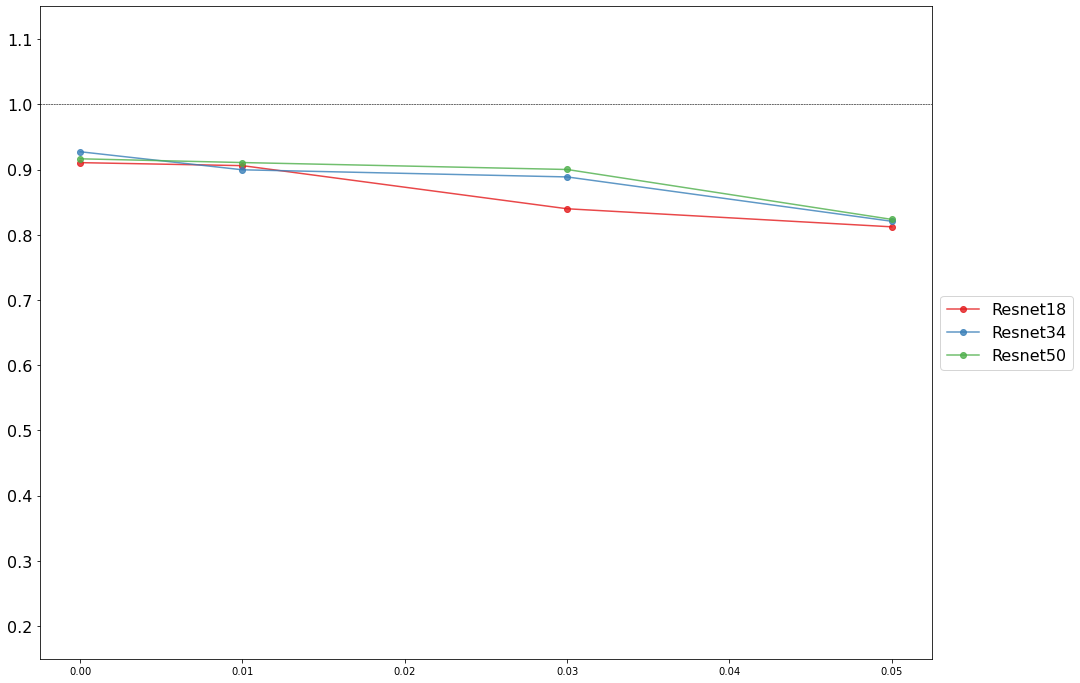

In [13]:
plt.figure(figsize=(16,12))
model_name_set = ['Resnet18', 'Resnet34', 'Resnet50']
for model_name in model_name_set:
    df = top_result_df.loc[top_result_df['model'] == model_name]

    x = [float(n) for n in df['noise']]
    #y = df['accuracy']
    y = df['f1_score_list'].apply(lambda s: np.mean(np.sort(s))).to_numpy()
    #y_std = df['accuracy_list'].apply(lambda s: np.std(np.sort(s))).to_numpy()
    
    plt.plot(x,y, '-o', label=model_name, alpha=0.8)
    #plt.fill_between(x, y-y_std, y+y_std, alpha=0.2)
    #plt.xticks(x)
    plt.ylim(0.15,1.15)
    plt.yticks(np.linspace(0.20, 1.10,10), fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.axhline(y=1.0, linewidth = 0.5, linestyle='--', color='k', alpha=0.5)
plt.show()

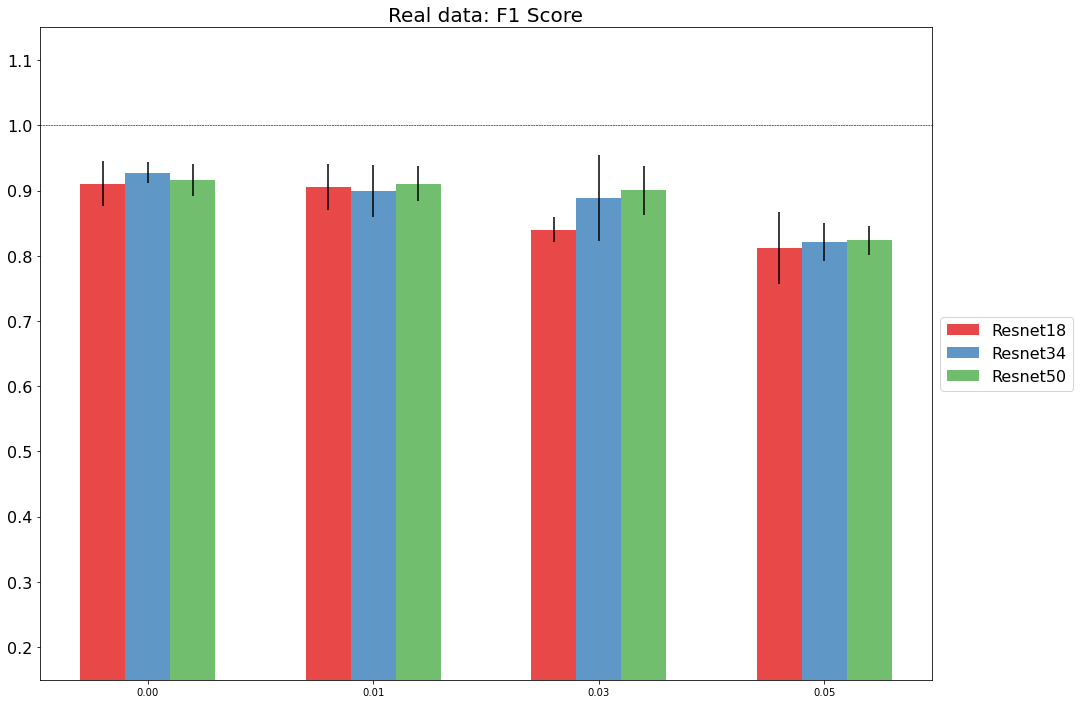

In [14]:
plt.figure(figsize=(16,12))
i=0
model_name_set = ['Resnet18', 'Resnet34', 'Resnet50']
for model_name in model_name_set:
    df = top_result_df.loc[top_result_df['model'] == model_name]

    x = [str(n) for n in df['noise']]
    #y = df['accuracy']
    y = df['f1_score_list'].apply(lambda s: np.mean(np.sort(s))).to_numpy()
    y_std = df['f1_score_list'].apply(lambda s: np.std(np.sort(s))).to_numpy()
    
    plt.bar(np.array(range(len(x)))+0.2*i, y, yerr=y_std+0.001, width=0.2, label=model_name, alpha=0.8)
    #plt.fill_between(x, y-y_std, y+y_std, alpha=0.2)
    plt.xticks(np.array(range(len(x)))-0.2+0.2*i, x)
    plt.ylim(0.15,1.15)
    plt.yticks(np.linspace(0.20, 1.10,10), fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.axhline(y=1.0, linewidth = 0.5, linestyle='--', color='k', alpha=0.5)
    i+=1
plt.title('Real data: F1 Score', fontsize=20)
plt.show()

In [15]:
top_result_df_selected['model_name'] = top_result_df_selected[['model', 'transfer']].apply(lambda s: str(s[0])+'_'+str(s[1]), axis=1)

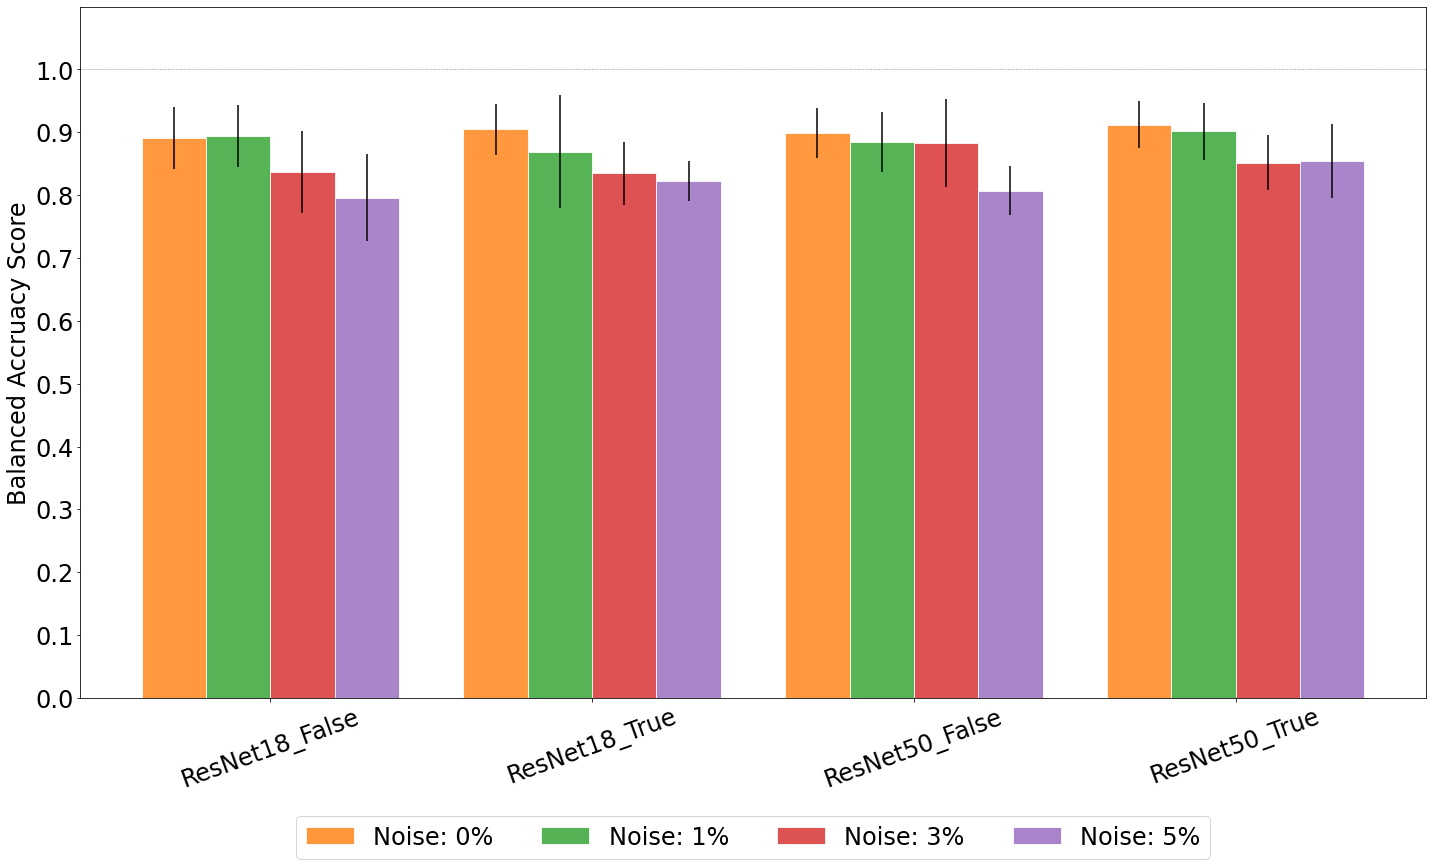

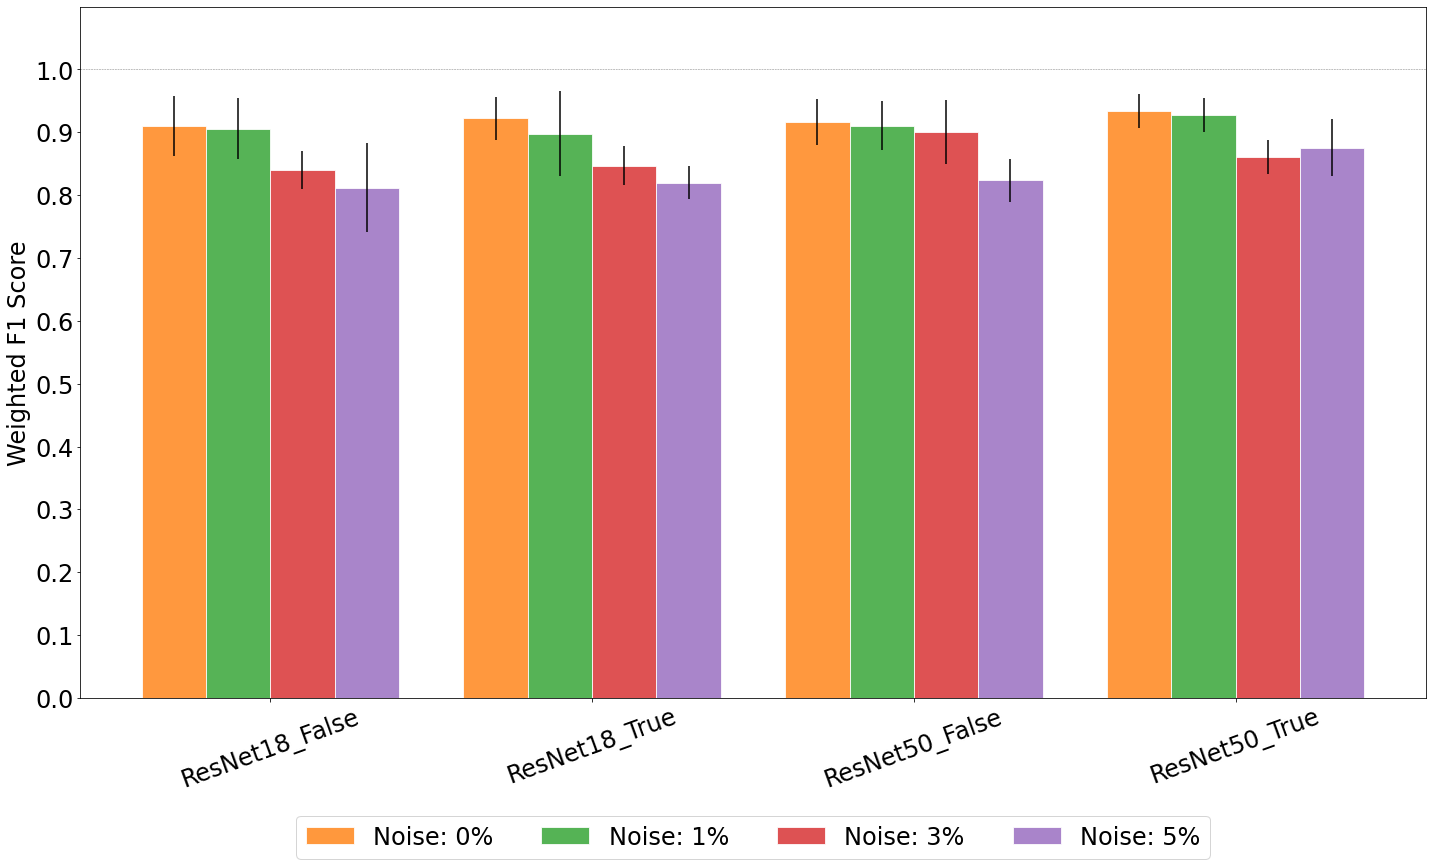

In [17]:
plt.figure(figsize=(20,12))
cnt = 0
#for name in ['Resnet18_False', 'Resnet18_True', 'Resnet34_False', 'Resnet34_True', 'Resnet50_False', 'Resnet50_True']:
for name in ['Resnet18_False', 'Resnet18_True', 'Resnet50_False', 'Resnet50_True']:    

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.00')]['balanced_accuracy_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.00')]['balanced_accuracy_std']
    plt.bar(cnt-0.3, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[1], edgecolor = 'w')

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.01')]['balanced_accuracy_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.01')]['balanced_accuracy_std']
    plt.bar(cnt-0.1, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[2], edgecolor = 'w')

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.03')]['balanced_accuracy_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.03')]['balanced_accuracy_std']
    plt.bar(cnt+0.1, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[3], edgecolor = 'w')

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.05')]['balanced_accuracy_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.05')]['balanced_accuracy_std']
    plt.bar(cnt+0.3, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[4], edgecolor = 'w')
   
    cnt += 1
    
patch_0 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[1], edgecolor = 'w', label = 'Noise: 0%')
patch_1 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[2], edgecolor = 'w', label = 'Noise: 1%')
patch_2 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[3], edgecolor = 'w', label = 'Noise: 3%')
patch_3 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[4], edgecolor = 'w', label = 'Noise: 5%')
plt.legend(handles = [patch_0, patch_1, patch_2, patch_3], loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol = 4, fontsize=24)
plt.axhline(y=1.0, linewidth = 0.5, linestyle='--', color='k', alpha=0.5)

plt.ylim(0.10,1.10)
plt.ylabel('Balanced Accruacy Score', fontsize=24)
plt.yticks(np.linspace(0.00, 1.00, 11), fontsize=24)
#plt.xticks(range(cnt), ['ResNet18_False', 'ResNet18_True', 'ResNet34_False', 'ResNet34_True', 'ResNet50_False', 'ResNet50_True'], fontsize=24, rotation=20)
plt.xticks(range(cnt), ['ResNet18_False', 'ResNet18_True', 'ResNet50_False', 'ResNet50_True'], fontsize=24, rotation=20)
# plt.title('UCI data: Balanced Accuracy Score', fontsize=32)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,12))
cnt = 0
#for name in ['Resnet18_False', 'Resnet18_True', 'Resnet34_False', 'Resnet34_True', 'Resnet50_False', 'Resnet50_True']:
for name in ['Resnet18_False', 'Resnet18_True', 'Resnet50_False', 'Resnet50_True']:    
    
    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.00')]['f1_score_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.00')]['f1_score_std']
    plt.bar(cnt-0.3, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[1], edgecolor = 'w')

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.01')]['f1_score_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.01')]['f1_score_std']
    plt.bar(cnt-0.1, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[2], edgecolor = 'w')

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.03')]['f1_score_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.03')]['f1_score_std']
    plt.bar(cnt+0.1, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[3], edgecolor = 'w')

    y = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.05')]['f1_score_mean']
    y_std = top_result_df_selected.loc[(top_result_df_selected['model_name']==name) & (top_result_df_selected['noise']=='0.05')]['f1_score_std']
    plt.bar(cnt+0.3, y, yerr=y_std+0.01, width=0.2, alpha=0.8, facecolor=plt.cm.tab10.colors[4], edgecolor = 'w')
   
    cnt += 1
    
patch_0 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[1], edgecolor = 'w', label = 'Noise: 0%')
patch_1 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[2], edgecolor = 'w', label = 'Noise: 1%')
patch_2 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[3], edgecolor = 'w', label = 'Noise: 3%')
patch_3 = mpatches.Patch(alpha=0.8, facecolor=plt.cm.tab10.colors[4], edgecolor = 'w', label = 'Noise: 5%')
plt.legend(handles = [patch_0, patch_1, patch_2, patch_3], loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol = 4, fontsize=24)
plt.axhline(y=1.0, linewidth = 0.5, linestyle='--', color='k', alpha=0.5)

plt.ylim(0.10,1.10)
plt.ylabel('Weighted F1 Score', fontsize=24)
plt.yticks(np.linspace(0.00, 1.00, 11), fontsize=24)
#plt.xticks(range(cnt), ['ResNet18_False', 'ResNet18_True', 'ResNet34_False', 'ResNet34_True', 'ResNet50_False', 'ResNet50_True'], fontsize=24, rotation=20)
plt.xticks(range(cnt), ['ResNet18_False', 'ResNet18_True', 'ResNet50_False', 'ResNet50_True'], fontsize=24, rotation=20)
# plt.title('UCI data: Weighted F1 Score', fontsize=32)
plt.tight_layout()
plt.show()